<a href="https://colab.research.google.com/github/SproulHimself/automated_image_classification_and_sorting/blob/master/auto_image_classification_github_colabNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Image Classification Notebook


## Working with blur

### Labels: not blurry = 0, blurry = 1

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 19.8MB/s 


In [0]:
import os
import csv
import cv2
import sys
import dlib
import keras
import imutils
import argparse
import numpy as np
import pandas as pd
from imutils import face_utils
from keras.optimizers import Adam, RMSprop
from keras.activations import relu
from keras.applications import VGG16, VGG19
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Flatten, Dense, Activation, Dropout, InputLayer
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, LeakyReLU
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
!mkdir mega_data

In [0]:
cd mega_data/

/content/mega_data


In [0]:
!ls

In [0]:
folder_id='************************************'
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()

for file in file_list:
  downloaded = drive.CreateFile({'id': file['id']})
  downloaded.GetContentFile(downloaded['title'])

In [0]:
!unzip blurry.zip
!unzip not_blurry.zip

In [0]:
!rm blurry.zip
!rm not_blurry.zip
!rm -rf __MACOSX

In [0]:
!ls

blinkModel.hdf5  haarcascade_frontalface_alt.xml	testing_model_save
blurry.zip	 not_blurry.zip				testing_weights_save
dataset.csv	 shape_predictor_68_face_landmarks.dat


In [0]:
cd ..

/content


In [0]:
!ls

adc.json  mega_data  sample_data


In [0]:
!pwd

/content


In [0]:
directory = 'mega_data/'

In [0]:
# get all the data in the directory split/test, and reshape them
ph_size = 224
data_all = ImageDataGenerator(rescale=1./255, 
                              horizontal_flip=True, 
                              vertical_flip=True).flow_from_directory( 
        directory, 
        target_size=(ph_size, ph_size), 
        batch_size = 13904, 
        seed = 123) 

Found 6952 images belonging to 2 classes.


In [0]:
print(len(os.listdir('mega_data/blurry/')))
print(len(os.listdir('mega_data/not_blurry//')))

3346
3606


In [0]:
images, labels = next(data_all)

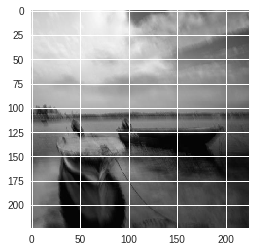

In [0]:
import matplotlib.pyplot as plt
plt.imshow(images[2])
plt.show()

In [0]:
images[2].shape

(224, 224, 3)

## Initial Modeling

In [0]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

In [0]:
#reshape into 1D arrays (only for densely connected network)
X = images.reshape(images.shape[0], -1)
y = np.reshape(labels[:,0], (len(labels),1))

In [0]:
y.shape

(6952, 1)

In [0]:
X.shape

(6952, 150528)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [0]:
print(X_train.shape)
print()
print(X_test.shape)

#### Base model (very poor)

In [0]:
base = Sequential()
base.add(Dense(128, activation='tanh', input_dim=150528)) #2 hidden layers
base.add(LeakyReLU(alpha=0.05))
base.add(Dense(1, activation='sigmoid'))

base.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
base_model = base.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=.1, verbose=1) 

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 23s 6ms/step - loss: 0.7120 - acc: 0.4922 - val_loss: 0.6918 - val_acc: 0.5275
Epoch 2/30
3600/3600 [==============================] - 22s 6ms/step - loss: 0.6939 - acc: 0.5031 - val_loss: 0.6992 - val_acc: 0.4725
Epoch 3/30
3600/3600 [==============================] - 22s 6ms/step - loss: 0.6937 - acc: 0.5075 - val_loss: 0.6917 - val_acc: 0.5300
Epoch 4/30
3600/3600 [==============================] - 23s 6ms/step - loss: 0.6939 - acc: 0.5028 - val_loss: 0.6997 - val_acc: 0.4725
Epoch 5/30
3600/3600 [==============================] - 22s 6ms/step - loss: 0.6928 - acc: 0.5092 - val_loss: 0.6919 - val_acc: 0.5275
Epoch 6/30
3600/3600 [==============================] - 22s 6ms/step - loss: 0.6937 - acc: 0.4986 - val_loss: 0.6955 - val_acc: 0.4725
Epoch 7/30
3600/3600 [==============================] - 22s 6ms/step - loss: 0.6931 - acc: 0.5119 - val_loss: 0.7020 - val_acc: 0.4725
Epoch 8/

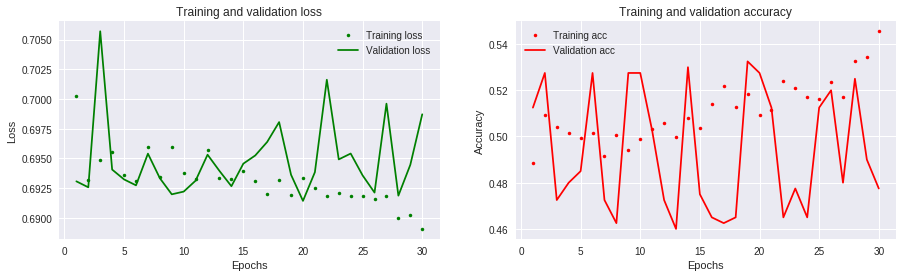

In [0]:
hist_dense = dense_fit.history
loss_values = hist_dense['loss']
val_loss_values = hist_dense['val_loss']
acc_values = hist_dense['acc'] 
val_acc_values = hist_dense['val_acc']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.20, random_state=123)

In [0]:
cnn = Sequential()
cnn.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(4, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(4, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [0]:
cnn_1 = cnn.fit(X_train, y_train, epochs=15,
                    batch_size=32, validation_split=.1)

Train on 3600 samples, validate on 400 samples
Epoch 1/15
3600/3600 [==============================] - 155s 43ms/step - loss: 0.6782 - acc: 0.5100 - val_loss: 0.6413 - val_acc: 0.4875
Epoch 2/15
3600/3600 [==============================] - 150s 42ms/step - loss: 0.5530 - acc: 0.7056 - val_loss: 0.5377 - val_acc: 0.5300
Epoch 3/15
3600/3600 [==============================] - 151s 42ms/step - loss: 0.3851 - acc: 0.9131 - val_loss: 0.3322 - val_acc: 0.9425
Epoch 4/15
3600/3600 [==============================] - 148s 41ms/step - loss: 0.4427 - acc: 0.8028 - val_loss: 0.7295 - val_acc: 0.5275
Epoch 5/15
3600/3600 [==============================] - 149s 41ms/step - loss: 0.5600 - acc: 0.7192 - val_loss: 0.7242 - val_acc: 0.5275
Epoch 6/15
3600/3600 [==============================] - 146s 41ms/step - loss: 0.7190 - acc: 0.4989 - val_loss: 0.6951 - val_acc: 0.5275
Epoch 7/15
3600/3600 [==============================] - 148s 41ms/step - loss: 0.5621 - acc: 0.6983 - val_loss: 0.3960 - val_acc: 0

In [0]:
results_test = cnn.evaluate(X_test, y_test, verbose=1)

print(results_test)

1000/1000 [==============================] - 19s 19ms/step
[0.11009847694635391, 0.968]


In [0]:
cnn.metrics_names

['loss', 'acc']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.20, random_state=123)

In [0]:
cnn2 = Sequential()
cnn2.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn2.add(MaxPooling2D((2, 2)))
cnn2.add(Conv2D(4, (3, 3), activation='relu'))
cnn2.add(MaxPooling2D((2, 2)))
cnn2.add(Flatten())
cnn2.add(Dense(4, activation='relu'))
cnn2.add(Dense(1, activation='sigmoid'))
cnn2.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [0]:
cnn_2 = cnn2.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=.1)

Train on 5004 samples, validate on 557 samples
Epoch 1/15
5004/5004 [==============================] - 200s 40ms/step - loss: 0.6828 - acc: 0.5356 - val_loss: 0.6673 - val_acc: 0.5135
Epoch 2/15
5004/5004 [==============================] - 199s 40ms/step - loss: 0.5850 - acc: 0.7184 - val_loss: 0.4295 - val_acc: 0.8654
Epoch 3/15
5004/5004 [==============================] - 197s 39ms/step - loss: 0.4091 - acc: 0.8431 - val_loss: 0.3764 - val_acc: 0.8707
Epoch 4/15
5004/5004 [==============================] - 197s 39ms/step - loss: 0.2416 - acc: 0.9129 - val_loss: 0.5726 - val_acc: 0.7630
Epoch 5/15
5004/5004 [==============================] - 198s 40ms/step - loss: 0.1916 - acc: 0.9327 - val_loss: 0.4133 - val_acc: 0.8259
Epoch 6/15
5004/5004 [==============================] - 197s 39ms/step - loss: 0.1582 - acc: 0.9440 - val_loss: 0.1341 - val_acc: 0.9587
Epoch 7/15
5004/5004 [==============================] - 199s 40ms/step - loss: 0.1446 - acc: 0.9522 - val_loss: 0.1958 - val_acc: 0

In [0]:
results_test2 = cnn2.evaluate(X_test, y_test, verbose=1)

print(results_test2)

1391/1391 [==============================] - 25s 18ms/step
[0.22752276504322574, 0.9151689432920268]


In [0]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [0]:
test = preprocess_image('blurry-picture-iphone.jpg')

In [0]:
test.shape

(1, 224, 224, 3)

In [0]:
imggg = np.squeeze(test, axis=0)
imggg.shape


(224, 224, 3)

array([[0.98502386]], dtype=float32)

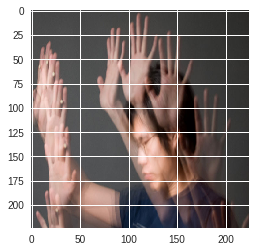

In [0]:
predictoneimage_cnn(cnn2, 'blurredvision-top.jpg')

In [0]:
# images[0].shape

In [0]:
cnn2.save('testing_model_save')

In [0]:
cnn2.save_weights('testing_weights_save')

In [0]:
def predictoneimage_cnn(model, path):
    img = load_img(path, target_size=(224, 224))
    plt.imshow(img)
    img = img_to_array(img)
    
    img = img/255
    img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    return predict

In [0]:
!pwd

/content


In [0]:
cnn3 = keras.models.load_model('testing_model_save')

array([[0.9752489]], dtype=float32)

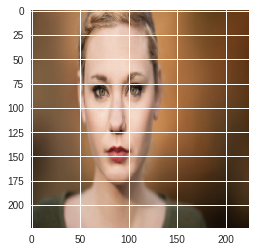

In [0]:
predictoneimage_cnn(cnn3, 'face.jpg')

# Getting test images from the web

In [0]:
!wget 'https://inst.eecs.berkeley.edu/~cs194-26/fa17/upload/files/proj3/cs194-26-aba/images/face.jpg'

--2019-02-06 16:26:13--  https://inst.eecs.berkeley.edu/~cs194-26/fa17/upload/files/proj3/cs194-26-aba/images/face.jpg
Resolving inst.eecs.berkeley.edu (inst.eecs.berkeley.edu)... 128.32.42.199
Connecting to inst.eecs.berkeley.edu (inst.eecs.berkeley.edu)|128.32.42.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66633 (65K) [image/jpeg]
Saving to: ‘face.jpg’

face.jpg            100%[===================>]  65.07K  --.-KB/s    in 0.1s    

2019-02-06 16:26:13 (456 KB/s) - ‘face.jpg’ saved [66633/66633]



In [0]:
!wget 'https://upload.wikimedia.org/wikipedia/commons/f/f5/Poster-sized_portrait_of_Barack_Obama.jpg' 

--2019-02-06 17:47:41--  https://upload.wikimedia.org/wikipedia/commons/f/f5/Poster-sized_portrait_of_Barack_Obama.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171503 (167K) [image/jpeg]
Saving to: ‘Poster-sized_portrait_of_Barack_Obama.jpg’

Poster-sized_portra 100%[===================>] 167.48K  --.-KB/s    in 0.04s   

2019-02-06 17:47:41 (4.04 MB/s) - ‘Poster-sized_portrait_of_Barack_Obama.jpg’ saved [171503/171503]



In [0]:
!wget  'https://positiveroutines.com/wp-content/uploads/2017/12/dark-haired-woman-eyes-closed-outdoors-nature.jpg'

--2019-02-06 16:26:16--  https://positiveroutines.com/wp-content/uploads/2017/12/dark-haired-woman-eyes-closed-outdoors-nature.jpg
Resolving positiveroutines.com (positiveroutines.com)... 104.28.29.96, 104.28.28.96, 2606:4700:30::681c:1d60, ...
Connecting to positiveroutines.com (positiveroutines.com)|104.28.29.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82067 (80K) [image/jpeg]
Saving to: ‘dark-haired-woman-eyes-closed-outdoors-nature.jpg’

dark-haired-woman-e 100%[===================>]  80.14K  --.-KB/s    in 0.05s   

2019-02-06 16:26:16 (1.61 MB/s) - ‘dark-haired-woman-eyes-closed-outdoors-nature.jpg’ saved [82067/82067]



In [0]:
!wget  'https://marketplace.canva.com/MACWcaWshhk/1/thumbnail_large/canva-pretty%2C-woman%2C-girl%2C-eyes%2C-closed%2C-skincare%2C-skin%2C-face-MACWcaWshhk.jpg'

--2019-02-06 16:26:20--  https://marketplace.canva.com/MACWcaWshhk/1/thumbnail_large/canva-pretty%2C-woman%2C-girl%2C-eyes%2C-closed%2C-skincare%2C-skin%2C-face-MACWcaWshhk.jpg
Resolving marketplace.canva.com (marketplace.canva.com)... 104.16.80.22, 104.16.78.22, 104.16.81.22, ...
Connecting to marketplace.canva.com (marketplace.canva.com)|104.16.80.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49043 (48K) [image/jpeg]
Saving to: ‘canva-pretty,-woman,-girl,-eyes,-closed,-skincare,-skin,-face-MACWcaWshhk.jpg’

canva-pretty,-woman 100%[===================>]  47.89K  --.-KB/s    in 0.01s   

2019-02-06 16:26:21 (3.31 MB/s) - ‘canva-pretty,-woman,-girl,-eyes,-closed,-skincare,-skin,-face-MACWcaWshhk.jpg’ saved [49043/49043]



In [0]:
!wget  'https://eyeqvc.com/wp-content/uploads/2017/10/portrait-of-happy-female-with-her-eyes-closed-picture-id665648670.jpg'

--2019-02-06 17:57:23--  https://eyeqvc.com/wp-content/uploads/2017/10/portrait-of-happy-female-with-her-eyes-closed-picture-id665648670.jpg
Resolving eyeqvc.com (eyeqvc.com)... 64.207.153.142
Connecting to eyeqvc.com (eyeqvc.com)|64.207.153.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92477 (90K) [image/jpeg]
Saving to: ‘portrait-of-happy-female-with-her-eyes-closed-picture-id665648670.jpg’

portrait-of-happy-f 100%[===================>]  90.31K   468KB/s    in 0.2s    

2019-02-06 17:57:23 (468 KB/s) - ‘portrait-of-happy-female-with-her-eyes-closed-picture-id665648670.jpg’ saved [92477/92477]



In [0]:
!wget 'https://cdna.artstation.com/p/assets/images/images/002/145/940/large/elena-sai-94.jpg?1457866784'

--2019-02-06 17:48:12--  https://cdna.artstation.com/p/assets/images/images/002/145/940/large/elena-sai-94.jpg?1457866784
Resolving cdna.artstation.com (cdna.artstation.com)... 104.16.226.51, 104.18.153.26
Connecting to cdna.artstation.com (cdna.artstation.com)|104.16.226.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 595173 (581K) [image/jpeg]
Saving to: ‘elena-sai-94.jpg?1457866784’

elena-sai-94.jpg?14 100%[===================>] 581.22K  --.-KB/s    in 0.05s   

2019-02-06 17:48:13 (10.9 MB/s) - ‘elena-sai-94.jpg?1457866784’ saved [595173/595173]



In [0]:
# timg = '/Users/sproul/Desktop/Friends/VaughnBBB.jpg'

o_img = 'face.jpg'
o2_img = 'Poster-sized_portrait_of_Barack_Obama.jpg'
o3_img = 'elena-sai-94.jpg?1457866784'



b_img = 'dark-haired-woman-eyes-closed-outdoors-nature.jpg'
b2_img = 'canva-pretty,-woman,-girl,-eyes,-closed,-skincare,-skin,-face-MACWcaWshhk.jpg'
b3_img = 'portrait-of-happy-female-with-her-eyes-closed-picture-id665648670.jpg'

In [0]:
# Test jpg files from internet

# https://macphunsoftware.cachefly.net/upload/SkylumHowto/shutterstock_2249804441x.jpg
# https://techinstyle.asus.com/wp-content/uploads/2017/12/bokeh-hero.jpg
# https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/blurry-city-lights-patrik-duda.jpg
# https://inst.eecs.berkeley.edu/~cs194-26/fa17/upload/files/proj3/cs194-26-aba/images/face.jpg

# https://upload.wikimedia.org/wikipedia/commons/f/f5/Poster-sized_portrait_of_Barack_Obama.jpg
# https://www.insidescience.org/sites/default/files/blurredvision-top.jpg
# https://www.crystalgraphicsimages.com/photo/portrait-relaxed-unshaven-male-closed-eyes-wears_cg2p33409214c_th.jpg
# https://us.123rf.com/450wm/korabkova/korabkova1510/korabkova151000009/46933382-%E6%98%8E%E3%82%8B%E3%81%84%E5%8C%96%E7%B2%A7%E3%81%A8%E5%B7%BB%E3%81%8D%E6%AF%9B%E3%81%AE%E7%BE%8E%E3%81%97%E3%81%84%E5%A5%B3%E6%80%A7%E3%81%AE%E3%82%AF%E3%83%AD%E3%83%BC%E3%82%BA-%E3%82%A2%E3%83%83%E3%83%97%E3%81%AE%E8%82%96%E5%83%8F%E7%94%BB.jpg?ver=6
# https://marketplace.canva.com/MACWcaWshhk/1/thumbnail_large/canva-pretty%2C-woman%2C-girl%2C-eyes%2C-closed%2C-skincare%2C-skin%2C-face-MACWcaWshhk.jpg
# https://positiveroutines.com/wp-content/uploads/2017/12/dark-haired-woman-eyes-closed-outdoors-nature.jpg
  

# Working with blinks

In [0]:
cd ..

/content


In [0]:
!mkdir eyes_data

In [0]:
cd eyes_data/

/content/eyes_data


In [0]:
folder_id='*********************************'
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()

for file in file_list:
  downloaded = drive.CreateFile({'id': file['id']})
  downloaded.GetContentFile(downloaded['title'])

In [0]:
!unzip closed_eyes_V3.zip
!unzip open_eyes_V2.zip

In [0]:
!rm closed_eyes_V3.zip
!rm open_eyes_V2.zip
!rm -rf __MACOSX

In [0]:
!ls

adc.json  eyes_data  mega_data	sample_data


In [0]:
directory2 = 'eyes_data'

In [0]:
# TRAIN ON 96 x 96 pixel images
data_all3 = ImageDataGenerator(rescale=1./255, rotation_range=.2, 
                              horizontal_flip=True, vertical_flip=True,
                              height_shift_range=0.2, width_shift_range=0.2,
                              ).flow_from_directory( 
        directory2, 
        target_size=(96, 96), 
        batch_size = 6000, 
        seed = 123)

Found 4926 images belonging to 2 classes.


In [0]:
# eye_images_resized[0]

In [0]:
print(len(os.listdir('eyes_data/closed_eyes/')))
print(len(os.listdir('eyes_data/open_eyes/')))

2464
2464


In [0]:
# eye_images, labels2 = next(data_all2)
eye_images_resized, labels3 = next(data_all3)

[0. 1.]


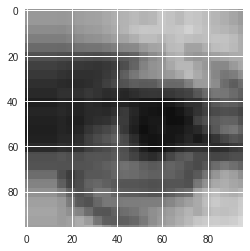

In [0]:
# .reshape((26,34))
print(labels3[92])
plt.imshow(eye_images_resized[92])
plt.show()

In [0]:
# Xe = eye_images.reshape(eye_images.shape[0], -1)
# ye = np.reshape(labels2[:,0], (len(labels2),1))
yr = np.reshape(labels3[:,0], (len(labels3),1))

In [0]:
Xe.shape

(4846, 1728)

In [0]:
Xe_train, Xe_test, ye_train, ye_test = train_test_split(eye_images, ye, test_size=0.20, random_state=123)

In [0]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(eye_images_resized, yr, test_size=0.20, random_state=123)

## Crop Eyes Here

### Labels:  open = 0, closed =1

In [0]:
predictor = dlib.shape_predictor('mega_data/shape_predictor_68_face_landmarks.dat')
face_cascade = cv2.CascadeClassifier('mega_data/haarcascade_frontalface_default.xml')

In [0]:
def detect(img, cascade = face_cascade , minimumFeatureSize=(20, 20)):
    if cascade.empty():
        raise (Exception("There was a problem loading your Haar Cascade xml file."))
    rects = cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=1, minSize=minimumFeatureSize)

    # if it doesn't return rectangle return array
    # with zero lenght
    if len(rects) == 0:
        return []

    #  convert last coord from (width,height) to (maxX, maxY)
    rects[:, 2:] += rects[:, :2]

    return rects

In [0]:
def cropEyes3(img):

#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     gray = cv2.imread(img, 0)
    gray = cv2.imread(img)

# detect the face at grayscale image
    te = detect(gray, minimumFeatureSize=(80, 80))

# if the face detector doesn't detect face
# return None, else if detects more than one faces
# keep the bigger and if it is only one keep one dim
    if len(te) == 0:
        return print('No face detected')
    elif len(te) > 1:
        face = te[0]
    elif len(te) == 1:
        [face] = te

# keep the face region from the whole frame
    face_rect = dlib.rectangle(left = int(face[0]), top = int(face[1]), 
                               right = int(face[2]), bottom = int(face[3]))

# determine the facial landmarks for the face region
    shape = predictor(gray, face_rect)
    shape = face_utils.shape_to_np(shape)

#  grab the indexes of the facial landmarks for the left and
#  right eye, respectively
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

# extract the left and right eye coordinates
    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]

# keep the upper and the lower limit of the eye
# and compute the height
    l_uppery = min(leftEye[1:3,1])
    l_lowy = max(leftEye[4:,1])
    l_dify = abs(l_uppery - l_lowy)
    lw = (leftEye[3][0] - leftEye[0][0])
    minxl = (leftEye[0][0] - ((50-lw)/2))
    maxxl = (leftEye[3][0] + ((50-lw)/2))
    minyl = (l_uppery - ((40-l_dify)/2))
    maxyl = (l_lowy + ((40-l_dify)/2))
    left_eye_rect = np.rint([minxl, minyl, maxxl, maxyl])
    left_eye_rect = left_eye_rect.astype(int)
    left_eye_image = gray[(left_eye_rect[1]):left_eye_rect[3], (left_eye_rect[0]):left_eye_rect[2]]

# same as left eye at right eye
    r_uppery = min(rightEye[1:3,1])
    r_lowy = max(rightEye[4:,1])
    r_dify = abs(r_uppery - r_lowy)
    rw = (rightEye[3][0] - rightEye[0][0])
    minxr = (rightEye[0][0]-((40-rw)/2))
    maxxr = (rightEye[3][0] + ((40-rw)/2))
    minyr = (r_uppery - ((32-r_dify)/2))
    maxyr = (r_lowy + ((32-r_dify)/2))
    right_eye_rect = np.rint([minxr, minyr, maxxr, maxyr])
    right_eye_rect = right_eye_rect.astype(int)
    right_eye_image = gray[right_eye_rect[1]:right_eye_rect[3], right_eye_rect[0]:right_eye_rect[2]]

# if it doesn't detect left or right eye return None
    if 0 in left_eye_image.shape or 0 in right_eye_image.shape:
        return print('No eye detected')
    
# resize for the conv net
    left_eye_image = cv2.resize(left_eye_image, (96, 96))
    right_eye_image = cv2.resize(right_eye_image, (96, 96))
    
# correct the color scheme
    left_eye_image = cv2.cvtColor(left_eye_image, cv2.COLOR_BGR2RGB)
    right_eye_image = cv2.cvtColor(right_eye_image, cv2.COLOR_BGR2RGB)
    
#     left_eye_image = cv2.cvtColor(left_eye_image, cv2.COLOR_GRAY2RGB)
#     right_eye_image = cv2.cvtColor(right_eye_image, cv2.COLOR_GRAY2RGB)
    

    right_eye_image = cv2.flip(right_eye_image, 1)
# return left and right eye
    return left_eye_image/255, right_eye_image/255

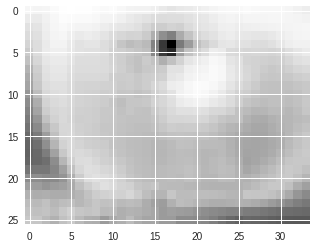

In [0]:
# original cropEyes output
plt.imshow(cropEyes(o_img)[0]);

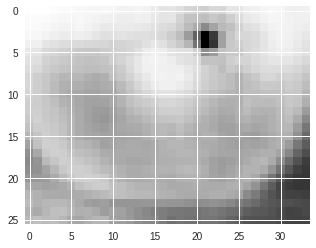

In [0]:
# original cropEyes output
plt.imshow(cropEyes(o_img)[1]);

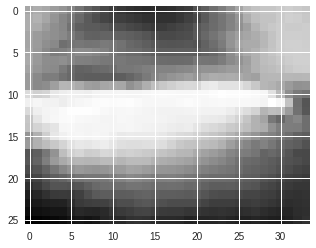

In [0]:
# original cropEyes output (blinking)
plt.imshow(cropEyes(b_img)[1]);

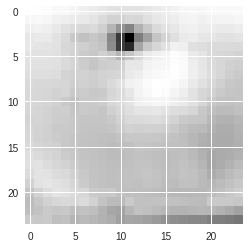

In [0]:
# cropEyes version 2 output
plt.imshow(cropEyes2(o_img)[0]);

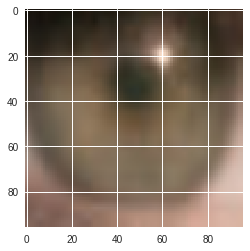

In [0]:
#  cropEyes version 3 output
plt.imshow(cropEyes3(o_img)[1]);

In [0]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img /= 255
#     img = np.expand_dims(img, axis=0)
#     img = preprocess_input(img)
    return img

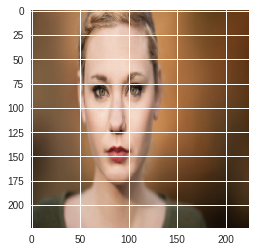

In [0]:
plt.imshow((preprocess_image(o_img)));

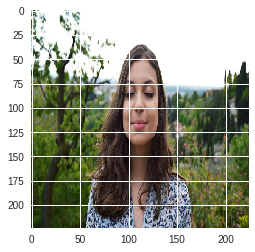

In [0]:
plt.imshow((preprocess_image(b_img)));

#### One of the experimental models (a poor one)

In [0]:
bcnn3 = Sequential()
bcnn3.add(Conv2D(16, (3, 3), activation='tanh', input_shape=(24, 24, 3)))
bcnn3.add(MaxPooling2D((2, 2)))
bcnn3.add(Conv2D(4, (3, 3), activation='tanh'))
bcnn3.add(MaxPooling2D((2, 2)))
bcnn3.add(Flatten())
bcnn3.add(Dense(4, activation='tanh'))
bcnn3.add(Dense(1, activation='sigmoid'))
bcnn3.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [0]:
cnn_bV2 = bcnn3.fit(Xe_train, ye_train, epochs=50, batch_size=32, validation_split=.1)

Train on 3488 samples, validate on 388 samples
Epoch 1/50
3488/3488 [==============================] - 6s 2ms/step - loss: 0.6869 - acc: 0.5476 - val_loss: 0.6849 - val_acc: 0.5052
Epoch 2/50
3488/3488 [==============================] - 6s 2ms/step - loss: 0.6739 - acc: 0.5889 - val_loss: 0.6770 - val_acc: 0.5464
Epoch 3/50
3488/3488 [==============================] - 6s 2ms/step - loss: 0.6621 - acc: 0.6184 - val_loss: 0.6671 - val_acc: 0.6031
Epoch 4/50
3488/3488 [==============================] - 5s 1ms/step - loss: 0.6501 - acc: 0.6373 - val_loss: 0.6580 - val_acc: 0.6366
Epoch 5/50
3488/3488 [==============================] - 3s 789us/step - loss: 0.6405 - acc: 0.6465 - val_loss: 0.6531 - val_acc: 0.6340
Epoch 6/50
3488/3488 [==============================] - 3s 817us/step - loss: 0.6345 - acc: 0.6560 - val_loss: 0.6487 - val_acc: 0.6314
Epoch 7/50
3488/3488 [==============================] - 3s 801us/step - loss: 0.6304 - acc: 0.6568 - val_loss: 0.6454 - val_acc: 0.6418
Epoch 8/5

In [0]:
def predictoneimage_cnnb(model, path):
#     plt.imshow(path)
    
    img = np.expand_dims(path, axis=0)
    img = np.expand_dims(img, axis=3)
#     img = load_img(path, target_size=(26, 34))
#     plt.imshow(img)
#     img = img_to_array(img)
#     img = img/255
#     img = np.expand_dims(img, axis=0) 
    predict = model.predict(img)
  
#     predict = model.predict(path)
    return predict

In [0]:
open_test0 = cropEyes(o_img)[0]
open_test1 = cropEyes(o_img)[1]

In [0]:
predictoneimage_cnnb(bcnn2, open_test0)

array([[0.3366145]], dtype=float32)

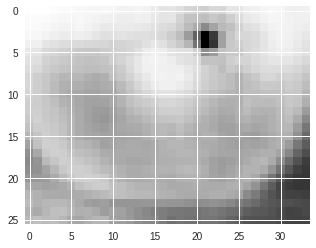

In [0]:
plt.imshow(open_test0);

In [0]:
rmodel = Sequential()

rmodel.add(Conv2D(64, (3,3), padding = 'same', input_shape=(96, 96, 3)))
rmodel.add(Activation('tanh'))
rmodel.add(MaxPooling2D(pool_size=(2,2)))
rmodel.add(Conv2D(64, (2,2), padding= 'same'))
rmodel.add(Activation('tanh'))
rmodel.add(MaxPooling2D(pool_size=(2, 2)))
rmodel.add(Conv2D(64, (2,2), padding='same'))
rmodel.add(Activation('tanh'))
rmodel.add(MaxPooling2D(pool_size=(2, 2)))
rmodel.add(Dropout(0.20))

rmodel.add(Flatten())
rmodel.add(Dense(512))
rmodel.add(Activation('tanh'))
# rmodel.add(Dense(256))
# rmodel.add(Activation('tanh'))
rmodel.add(Dense(1))
rmodel.add(Activation('sigmoid'))

	
rmodel.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
resized_test = rmodel.fit(Xr_train, yr_train, epochs=25, batch_size=32, validation_split=.1)

Instructions for updating:
Use tf.cast instead.
Train on 3546 samples, validate on 394 samples
Epoch 1/25
3546/3546 [==============================] - 109s 31ms/step - loss: 0.8648 - acc: 0.6038 - val_loss: 0.5537 - val_acc: 0.7310
Epoch 2/25
3546/3546 [==============================] - 106s 30ms/step - loss: 0.5753 - acc: 0.6968 - val_loss: 0.5364 - val_acc: 0.7284
Epoch 3/25
3546/3546 [==============================] - 107s 30ms/step - loss: 0.5355 - acc: 0.7276 - val_loss: 0.5023 - val_acc: 0.7513
Epoch 4/25
3546/3546 [==============================] - 108s 30ms/step - loss: 0.5438 - acc: 0.7222 - val_loss: 0.4761 - val_acc: 0.7944
Epoch 5/25
3546/3546 [==============================] - 107s 30ms/step - loss: 0.4863 - acc: 0.7631 - val_loss: 0.5120 - val_acc: 0.7437
Epoch 6/25
3546/3546 [==============================] - 107s 30ms/step - loss: 0.4489 - acc: 0.7930 - val_loss: 0.4166 - val_acc: 0.8249
Epoch 7/25
3546/3546 [==============================] - 108s 30ms/step - loss: 0.42

In [0]:
yr_pred = rmodel.predict(Xr_test, verbose=1, batch_size=32)

986/986 [==============================] - 8s 8ms/step


In [0]:
yr_label_pred = []

for e in yr_pred:
  if e <= .5:
    e == 0.
  else:
    e == 1.
  yr_label_pred.append(np.round(e))

In [0]:
# ye_label_pred

In [0]:
yr_pred[0] > .5

array([False])

In [0]:
accuracy_score(yr_test, yr_label_pred)

0.8782961460446247

In [0]:
f1_score(yr_test, yr_label_pred)

0.8854961832061068

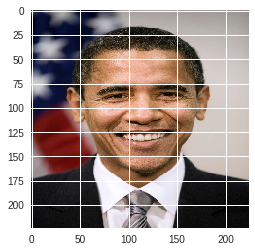

In [0]:
plt.imshow(preprocess_image(o2_img))

In [0]:
def preprocess_test(img, flip=False):
#   img = cropEyes2(img)[0]

#   img = np.expand_dims(img, axis=2)
#   img = np.concatenate((img, img, img), axis=2)
  img = np.expand_dims(img, axis=0)
  if flip == True:
      img = np.fliplr(img)
  return img

In [0]:
def predict_image_test(model, img):
    
    plt.imshow(img)
    
    img = preprocess_test(img, flip=False)
    
#     img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    return predict

In [0]:
cropEyes3(o_img)[1].shape

(96, 96, 3)

## Blink Test Here

array([[0.96682256]], dtype=float32)

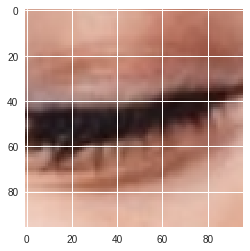

In [0]:
predict_image_test(rmodel, cropEyes3(b3_img)[0])

# Further Explorations...
(To be continued)

## Transfer Learning

In [0]:
from keras.applications import inception_v3

In [0]:
imagenet = inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new = imagenet.output
imagenet_new = GlobalAveragePooling2D()(imagenet_new)
imagenet_new = Dense(64,activation='relu')(imagenet_new) #we add dense layers so that the model can learn more complex functions and classify for better results.
# imagenet_new = Dense(64,activation='relu')(imagenet_new) #dense layer 2
# imagenet_new = Dense(64,activation='relu')(imagenet_new) #dense layer 3
preds = Dense(1, activation='sigmoid')(imagenet_new) #final layer with softmax activation

In [0]:
imagenet_model = Model(inputs=imagenet.input, outputs=preds)

In [0]:
# for i,layer in enumerate(imagenet_model.layers):
#   print(i, layer.name)

In [0]:
# or if we want to set the first 311 layers of the network to be non-trainable
# for layer in imagenet_model.layers[:311]:
#     layer.trainable=False
# for layer in imagenet_model.layers[311:]:
#     layer.trainable=True
for layer in imagenet_model.layers:
    layer.trainable=True

In [0]:
imagenet_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

array([0., 1.], dtype=float32)

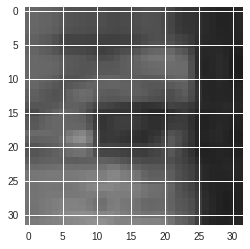

In [0]:
# imagenet_model.fit(Xe_train, ye_train, epochs=10,
#                    batch_size=32, validation_split=.1)
plt.imshow(eye_images_resized[312])
labels2[312]

In [0]:
input_shape = (32, 32, 3)

In [0]:
# # this could also be the output a different Keras model or layer
# # this assumes K.image_data_format() == 'channels_last'
# input_tensor = Input(shape=(224, 224, 3))  

# model = InceptionV3(input_tensor=input_tensor, weights='imagenet',
#                     include_top=False)

In [0]:
vgg = VGG16(include_top=False, weights='imagenet',  input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

In [0]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, Xr_train)
# validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape)
#       '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3876, 512)


In [0]:
test_eye = np.expand_dims(preprocess_test(cropEyes3(b_img)[1]), axis=0)

In [0]:
test_eye.shape

(1, 32, 32, 3)

In [0]:
azzz = get_bottleneck_features(vgg_model, test_eye)

In [0]:
input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))

# model = Sequential()
# model.add(vgg_model)

model.add(Dense(34, activation='relu', input_dim=34))
# model.add(Dropout(0.3))
model.add(Dense(34, activation='relu'))
model.add(Dense(17, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 34)                17442     
_________________________________________________________________
dense_67 (Dense)             (None, 34)                1190      
_________________________________________________________________
dense_68 (Dense)             (None, 17)                595       
_________________________________________________________________
dropout_17 (Dropout)         (None, 17)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 18        
Total params: 19,245
Trainable params: 19,245
Non-trainable params: 0
_________________________________________________________________


In [0]:
# pd.set_option('max_colwidth', -1)
# layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [0]:
history = model.fit(train_features_vgg, ye_train,
                    validation_split=.1,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

Train on 3488 samples, validate on 388 samples
Epoch 1/10
3488/3488 [==============================] - 54s 15ms/step - loss: 0.6618 - acc: 0.6385 - val_loss: 0.6193 - val_acc: 0.7990
Epoch 2/10
3488/3488 [==============================] - 2s 551us/step - loss: 0.5744 - acc: 0.7867 - val_loss: 0.5314 - val_acc: 0.8119
Epoch 3/10
3488/3488 [==============================] - 2s 577us/step - loss: 0.4918 - acc: 0.8188 - val_loss: 0.4579 - val_acc: 0.8067
Epoch 4/10
3488/3488 [==============================] - 2s 564us/step - loss: 0.4303 - acc: 0.8317 - val_loss: 0.4138 - val_acc: 0.8351
Epoch 5/10
3488/3488 [==============================] - 2s 569us/step - loss: 0.3998 - acc: 0.8343 - val_loss: 0.3872 - val_acc: 0.8299
Epoch 6/10
3488/3488 [==============================] - 2s 552us/step - loss: 0.3786 - acc: 0.8400 - val_loss: 0.3713 - val_acc: 0.8273
Epoch 7/10
3488/3488 [==============================] - 2s 596us/step - loss: 0.3679 - acc: 0.8452 - val_loss: 0.3597 - val_acc: 0.8273
E

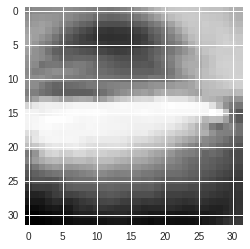

In [0]:
plt.imshow(cropEyes3(b_img)[1])